In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
class InceptionV3(nn.Module):
    def __init__(self, num_classes=2, aux_logits=False, transform_input=False):
        super(InceptionV3, self).__init__()
        self.inception = models.inception_v3(pretrained=False, num_classes=num_classes, aux_logits=aux_logits, transform_input=transform_input)

    def forward(self, x):
        return self.inception(x)

In [3]:
# Define the DeepDream model
class DeepDream(nn.Module):
    def __init__(self, model, layer_idx):
        super(DeepDream, self).__init__()
        self.features = self.get_required_layers(model, layer_idx)

    def forward(self, x):
        return self.features(x)

    def get_required_layers(self, model, layer_idx):
        # Extract the desired layers from the InceptionV3 model
        if isinstance(model, InceptionV3):
            # InceptionV3 has multiple branches, so we need to extract from a specific submodule
            return nn.Sequential(*list(model.inception.children())[:layer_idx+1])
        elif isinstance(model, nn.Module):
            return model  # For simplicity, using the entire model
        else:
            raise ValueError("Unsupported model type")

In [4]:
def deep_dream(image_tensor, model, layer_idx, iterations, lr, octave_scale, output_path):
    # Convert image tensor to nn.Parameter
    img = nn.Parameter(image_tensor.to(device))

    # Define the deep dream model
    dream_model = DeepDream(model, layer_idx).to(device)

    # Define the optimizer
    optimizer = optim.Adam([img], lr=lr)

    # DeepDream iterations
    for i in range(iterations):
        optimizer.zero_grad()
        features = dream_model(img)
        loss = features.norm()
        loss.backward()
        optimizer.step()

        # Apply the octave scaling
        img.data = img.data + octave_scale * img.grad.data

        # Zero the gradient
        img.grad.data.zero_()

        # Clip the image values to be in the valid range
        img.data = torch.clamp(img.data, 0, 1)

    # Save the final deep dream image
    result = transforms.ToPILImage()(img.squeeze(0).cpu())
    result.save(output_path)

In [5]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify the layer index for deep dream (you can experiment with different layers)
layer_index = 10

iterations = 20
learning_rate = 0.01
octave_scale = 1.4

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to the same dimensions as expected by InceptionV3
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to the same dimensions as expected by InceptionV3
    transforms.ToTensor()
])

In [7]:
model = InceptionV3().to(device)

/home/user/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/user/.local/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [8]:
train_dataset = datasets.ImageFolder(root='./data/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='./data/validation', transform=test_transform)

In [9]:
train_dataset_deepdream = datasets.ImageFolder(root='./data_deepdream2/train', transform=train_transform)
test_dataset_deepdream = datasets.ImageFolder(root='./data_deepdream2/test', transform=test_transform)

In [10]:
train_dataloader = DataLoader(train_dataset_deepdream, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset_deepdream, batch_size=32, shuffle=True)

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X)
        loss = loss_fn(preds, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [12]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        all_preds = []
        all_labels = []
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            num_same += (preds == y).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
        
        print(f'Average loss: {total_loss / len(dataloader.dataset)}')
        print(f'Accuracy: {num_same / len(dataloader.dataset)}')

        return num_same / len(dataloader.dataset), all_labels, all_preds

In [13]:
class_weights = [0.42, 0.58]
class_weights = torch.tensor(class_weights).to(device)

In [14]:
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters())
model.to(device)

num_epochs = 10
best_accuracy = 0.0
best_labels = None
best_preds = None

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    accuracy, all_labels, all_preds = test_loop(test_dataloader, model, loss_fn, device)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_labels = all_labels
        best_preds = all_preds

print(f'Best Accuracy: {best_accuracy}')

Epoch 1/10
Average loss: 0.06603169241547585
Accuracy: 0.572
Epoch 2/10
Average loss: 0.023084566712379455
Accuracy: 0.577
Epoch 3/10
Average loss: 0.040794728457927705
Accuracy: 0.589
Epoch 4/10
Average loss: 0.160586894094944
Accuracy: 0.585
Epoch 5/10
Average loss: 0.03263868346810341
Accuracy: 0.616
Epoch 6/10
Average loss: 0.029257659435272216
Accuracy: 0.627
Epoch 7/10
Average loss: 0.05355836686491966
Accuracy: 0.655
Epoch 8/10
Average loss: 0.024428653091192246
Accuracy: 0.59
Epoch 9/10
Average loss: 0.03188531494140625
Accuracy: 0.612
Epoch 10/10
Average loss: 0.0242844800055027
Accuracy: 0.663
Best Accuracy: 0.663


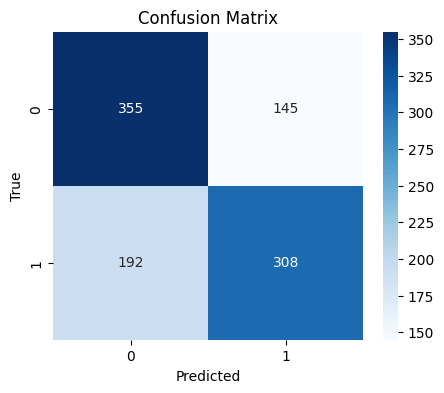

In [15]:
conf_matrix = confusion_matrix(best_labels, best_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()